In [58]:
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt
import time

In [22]:
IMG_SIZE = 28
NUM_OF_CLASSES = 10

## Load and visualize the MNIST dataset

In [49]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [50]:
def print_dataset_shape(train_X, train_y, test_X, test_y):
    print('X_train: ' + str(train_X.shape))
    print('Y_train: ' + str(train_y.shape))
    print('X_test:  ' + str(test_X.shape))
    print('Y_test:  ' + str(test_y.shape))


print_dataset_shape(train_X, train_y, test_X, test_y)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


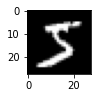

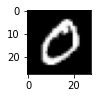

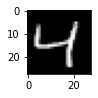

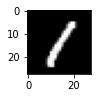

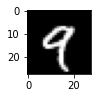

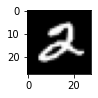

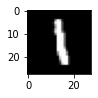

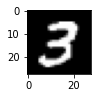

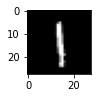

In [17]:

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
    plt.show()

In [51]:
def norm_and_unroll(X, y):
    X = X / 255.
    X = X.reshape((X.shape[0], IMG_SIZE ** 2))

    y = np.eye(NUM_OF_CLASSES)[y]
    return X, y

In [52]:
test_X, test_y = norm_and_unroll(test_X, test_y)
train_X, train_y = norm_and_unroll(train_X, train_y)

In [53]:
print_dataset_shape(train_X, train_y, test_X, test_y)

X_train: (60000, 784)
Y_train: (60000, 10)
X_test:  (10000, 784)
Y_test:  (10000, 10)


## Define activations and loss functions

In [56]:
def ReLU(x):
    return np.maximum(x, 0)


def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)


def derivative_ReLU(x):
    return np.where(x > 0., 1., 0.)


def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))


def cross_entropy_loss(y_true, y_pred):
    return np.mean(-np.sum(y_true * np.log(y_pred), axis=1))

## Fully connected neural network

In [98]:
class FCNet:
    def __init__(self, input_layer, hidden_layer, output_layer, activations=None, learning_rate=0.1):
        if activations is None:
            activations = [ReLU, softmax]
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.learning_rate = learning_rate

        self.w = [np.random.normal(0, np.sqrt(2 / input_layer), (input_layer, hidden_layer)),
                  np.random.normal(0, np.sqrt(2 / (input_layer + output_layer)), (hidden_layer, output_layer))]

        self.b = [np.zeros((1, hidden_layer)),
                  np.zeros((1, output_layer))]

        self.v = [np.zeros((1, hidden_layer)),
                  np.zeros((1, output_layer))]

        self.u = [np.zeros((1, hidden_layer)),
                  np.zeros((1, output_layer))]

        self.activations = activations

    def forward_pass(self, x):
        for layer in range(2):
            self.v[layer] = x @ self.w[layer] + self.b[layer]
            self.u[layer] = self.activations[layer](self.v[layer])
            x = self.u[layer]

        return x

    def backward_pass(self, x_train, y_train):
        dv2 = (self.u[1] - y_train) / self.u[1].shape[0]
        dw1 = self.u[0].T @ dv2
        db1 = np.sum(dv2, axis=0, keepdims=True)
        dv1 = dv2 @ self.w[1].T * np.where(self.v[0] > 0, 1, 0)
        dw0 = x_train.T @ dv1
        db0 = np.sum(dv1, axis=0, keepdims=True)

        self.w[1] -= self.learning_rate * dw1
        self.b[1] -= self.learning_rate * db1
        self.w[0] -= self.learning_rate * dw0
        self.b[0] -= self.learning_rate * db0

    def train(self, x_train, y_train, epochs=20, batch_size=32):
        start_time = time.time()
        time_per_epoch = start_time
        for epoch in range(epochs):
            start_epoch_time = time.time()
            idx = 0
            while idx + batch_size <= x_train.shape[0]:
                x_batch = x_train[idx: idx + batch_size]
                y_batch = y_train[idx: idx + batch_size]
                y_pred = self.forward_pass(x_batch)
                self.backward_pass(x_batch, y_batch)
                idx += batch_size
            time_per_epoch = time.time() - start_epoch_time
            y_pred = self.forward_pass(x_train)
            acc_per_epoch = accuracy(y_train, y_pred)
            loss_per_epoch = cross_entropy_loss(y_train, y_pred)
            print(f"Epoch: {epoch}; Accuracy: {acc_per_epoch}; Loss: {loss_per_epoch}; Time: {time_per_epoch:.2f}s")
        total_time = (time.time() - start_time)
        print(f"Total training time {total_time}")

    def test(self, x_test, y_test):
        y_pred = self.forward_pass(x_test)
        acc = accuracy(y_test, y_pred)
        loss = cross_entropy_loss(y_test, y_pred)
        print(f"Test Accuracy: {acc:.3f}; Test Loss: {loss:.3f}")
        return acc, loss



## Train & Test

In [99]:
HIDDEN_LAYER_SIZE = 30
INPUT_SIZE = IMG_SIZE ** 2
LEARNING_RATE = 0.1

fcnn = FCNet(INPUT_SIZE, HIDDEN_LAYER_SIZE, NUM_OF_CLASSES, learning_rate=LEARNING_RATE)

In [100]:
NUM_OF_EPOCHS = 20
fcnn.train(train_X, train_y, NUM_OF_EPOCHS)

Epoch: 0; Accuracy: 0.9232; Loss: 0.2532102852726377; Time: 1.03s
Epoch: 1; Accuracy: 0.9458166666666666; Loss: 0.17835749659113043; Time: 0.96s
Epoch: 2; Accuracy: 0.95495; Loss: 0.14726105308899223; Time: 0.84s
Epoch: 3; Accuracy: 0.9619; Loss: 0.1264606110026693; Time: 0.91s
Epoch: 4; Accuracy: 0.9651; Loss: 0.11556827603329493; Time: 1.04s
Epoch: 5; Accuracy: 0.9674666666666667; Loss: 0.10569554877505451; Time: 0.82s
Epoch: 6; Accuracy: 0.9696333333333333; Loss: 0.09812259556799655; Time: 0.82s
Epoch: 7; Accuracy: 0.9714833333333334; Loss: 0.09156679931297937; Time: 0.74s
Epoch: 8; Accuracy: 0.9729333333333333; Loss: 0.08706877479268837; Time: 0.65s
Epoch: 9; Accuracy: 0.97405; Loss: 0.0824766593457101; Time: 0.75s
Epoch: 10; Accuracy: 0.9747666666666667; Loss: 0.0791215296497319; Time: 0.70s
Epoch: 11; Accuracy: 0.9755333333333334; Loss: 0.07599877013167296; Time: 0.72s
Epoch: 12; Accuracy: 0.97595; Loss: 0.07428299725630925; Time: 0.68s
Epoch: 13; Accuracy: 0.9771; Loss: 0.071686

In [101]:
acc, loss = fcnn.test(test_X, test_y)

Test Accuracy: 0.962; Test Loss: 0.152
